<a href="https://colab.research.google.com/github/HemantAjmer/Fake-news-detector-model/blob/main/Fake%20news%20dectector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [2]:
fake_df = pd.read_csv("https://drive.google.com/uc?export=download&id=10kmvh-G10dZP5lCvwrAVtXE4U7dFk7sq")
true_df = pd.read_csv("https://drive.google.com/uc?export=download&id=1Q8VCP54NSO2iXjJzcYizJJxD1K5x_fDx")

In [3]:
# Add labels and clean data
fake_df['label'] = 0
true_df['label'] = 1

In [4]:
# Remove unnecessary columns
columns_to_drop = ["title", "date", "subject"]
fake_df = fake_df.drop(columns=columns_to_drop)
true_df = true_df.drop(columns=columns_to_drop)

In [5]:
# Combine datasets
combined_df = pd.concat([fake_df, true_df], ignore_index=True)

In [6]:
# Clean data
combined_df = combined_df.drop_duplicates()
print(len(combined_df))

38647


In [7]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
# Text preprocessing function
def preprocess_text(text):
    # Normalization
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()

    # Tokenization and lemmatization
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Stopword removal and filtering
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if
              word not in stop_words and
              len(word) > 3 and
              word.isalpha()]

    return tokens

In [9]:
# Prepare features and labels
text_samples = combined_df['text'].tolist()
labels = combined_df['label']

In [10]:
# Preprocess all texts
processed_texts = [preprocess_text(text) for text in text_samples]

In [11]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    processed_texts, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

In [12]:
# Tokenization and sequencing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 163100


In [13]:
# Padding sequences
max_length = 150
X_train = pad_sequences(sequences_train, maxlen=max_length, padding='post')
X_test = pad_sequences(sequences_test, maxlen=max_length, padding='post')

In [14]:
# Encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [15]:
# Convert to categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [16]:
# Build LSTM model
def create_model():
    inputs = Input(shape=(max_length,))
    x = Embedding(vocab_size, 128)(inputs)
    x = Dropout(0.4)(x)
    x = LSTM(128, return_sequences=True)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [17]:
model = create_model()
model.summary()

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=128
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 150, 128)            │      20,876,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 150, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 150, 128)            │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,016,770 (80.17 MB)

 Trainable params: 21,016,770 (80.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.7593 - loss: 0.4677 - val_accuracy: 0.8188 - val_loss: 0.3695
Epoch 2/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8900 - loss: 0.2949 - val_accuracy: 0.9342 - val_loss: 0.1689
Epoch 3/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9557 - loss: 0.1291 - val_accuracy: 0.9501 - val_loss: 0.1457
Epoch 4/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9780 - loss: 0.0659 - val_accuracy: 0.9696 - val_loss: 0.0846
Epoch 5/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9884 - loss: 0.0376 - val_accuracy: 0.9740 - val_loss: 0.0748
Epoch 6/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9945 - loss: 0.0204 - val_accuracy: 0.9687 - val_loss: 0.0955
Epoch 7/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9950 - loss: 0.0159 - val_accuracy: 0.9710 - val_loss: 0.1076
Epoch 8/10
242/242 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9981 - loss: 0.0083 - val

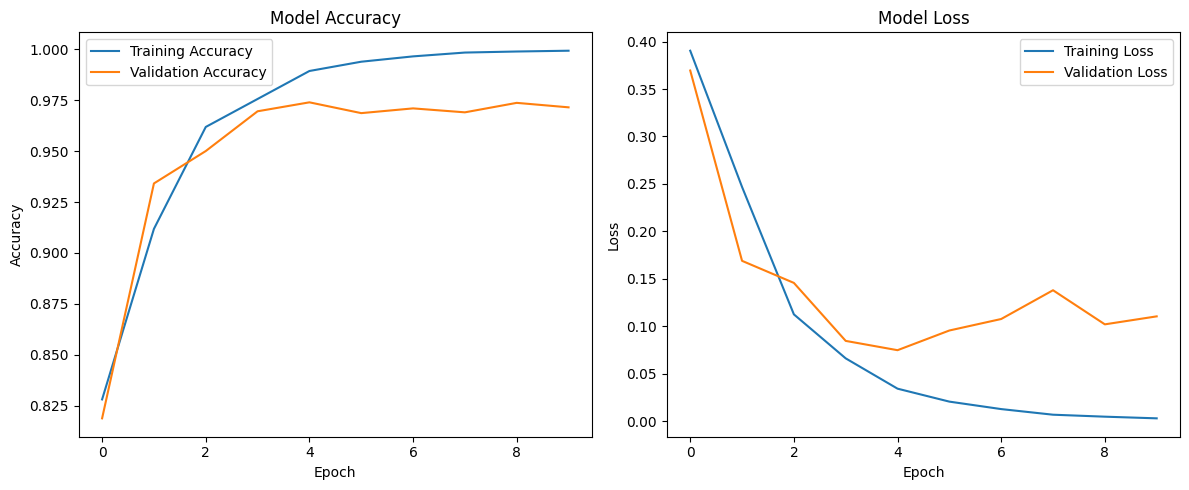

In [18]:
# Visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Evaluation
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


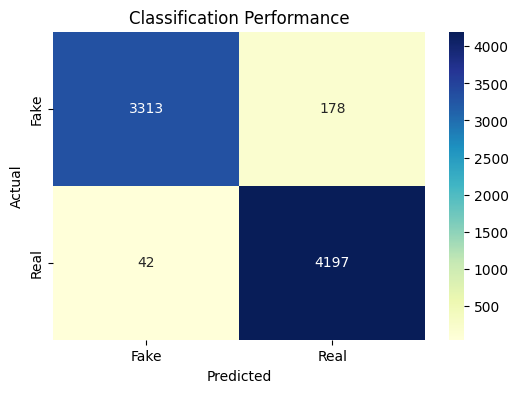

In [20]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Classification Performance')
plt.show()